# Verifying the Dataset

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import PIL


## Constants

In [4]:
UNKNOWN = 'Unknown'
VALUES = ['5', '10', '25', '50', '100']
SIDES = ['Up', 'Down']
EDITIONS = ['Old', 'New']
SORTED_COINS_DIR = './sorted_coins'

## Load JSON

In [45]:
def load_json(filename):
	with open(filename) as f:
		return json.load(f)

In [46]:
import os
from typing import Dict
from ViaV2Json import ImageMetadata

filename = list(filter(lambda name: name.startswith('TCC_MBA_Coins') , os.listdir('.')))[-1]
json_data = load_json(filename)

# Image metadata is where we have the regions we need
images_data: Dict[str, ImageMetadata] = json_data['_via_img_metadata']

In [47]:
from ViaV2Json import RegionAttributes

def is_uncertain(attributes: RegionAttributes):
	"""
	Returns true if the region is uncertain
	"""
	
	return attributes.get('Uncertain', {}).get('X', False)


## Check for classification mistakes

In [48]:
# Until image 20220827_130606, old coins with values 5, 10 or 50 are undistinguishable when down, so they must be uncertain.
from colorama import Style

print(Style.BRIGHT + f'Classification Errors')

for metadata in images_data.values():
	filename = metadata['filename']
	
	if filename >= '20220827_130606.jpg': 
		continue
	
	for regionId, region in enumerate(metadata['regions']): 
		region_attr = region['region_attributes']
		
		side, edition, value = region_attr['Side'], region_attr['Edition'], region_attr['Value']

		if side == 'Down' and edition == 'Old' and int(value) != 25 and is_uncertain(region_attr) == False:
			print(f'{filename} - {regionId + 1}')



Classification Errors


## Dataset Balancing Analysis


Let's verify if the dataset is balanced between classes.

### Create Dataframe


In [49]:
# Load dataframe df with all the image data
from colorama import Fore, Back, Style

df = pd.DataFrame()

# Get number of coins for each type
for image in images_data:
    for regionId, region in enumerate(images_data[image]['regions']):
        attributes = region['region_attributes']
        # add row to dataframe with image name, region id, coin value, edition and side
        try:
            df = df.append({
                # image name is just the first 19 characters of the image path
                'ImageName': image[:19],
                'ImageId': image,
                'RegionId': regionId + 1,
                'Value': attributes.get('Value', UNKNOWN),
                'Edition': attributes.get('Edition', UNKNOWN),
                'Side': attributes.get('Side', UNKNOWN),
                'Uncertain': is_uncertain(attributes),
                #'FullName': f'{attributes["Value"]} {attributes["Edition"]} {attributes["Side"]}'
            }, ignore_index=True)
        except:
            print(Fore.RED + Style.BRIGHT +
                  f'Error on image {image[:19]} region {regionId + 1}', )

df.head()


C:\Users\heavy\AppData\Local\Temp\ipykernel_19196\2744280646.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
C:\Users\heavy\AppData\Local\Temp\ipykernel_19196\2744280646.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
C:\Users\heavy\AppData\Local\Temp\ipykernel_19196\2744280646.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
C:\Users\heavy\AppData\Local\Temp\ipykernel_19196\2744280646.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
C:\Users\heavy\AppData\Local\Temp\ipykernel_19196\2744280646.py:12: FutureWarning: The frame.append method is deprecated

,ImageName,ImageId,RegionId,Value,Edition,Side,Uncertain
0,20220827_125135.jpg,20220827_125135.jpg5530448,1,25,New,Up,False
1,20220827_125135.jpg,20220827_125135.jpg5530448,2,10,New,Up,False
2,20220827_125135.jpg,20220827_125135.jpg5530448,3,50,Old,Up,False
3,20220827_125135.jpg,20220827_125135.jpg5530448,4,5,New,Up,False
4,20220827_125135.jpg,20220827_125135.jpg5530448,5,5,New,Up,False


### Remove uncertain classes

In [50]:
# Those classes are the ones that we are not sure about the value of the coin.
print(f'Number of coins: {len(df)}')
df = df[df['Uncertain'] == 0]
print(f'Number of coins without uncertain: {len(df)}')

Number of coins: 2807
Number of coins without uncertain: 2700


### Analyze the distribution of coins

<AxesSubplot:title={'center':'Coin Editions'}, ylabel='Edition'>

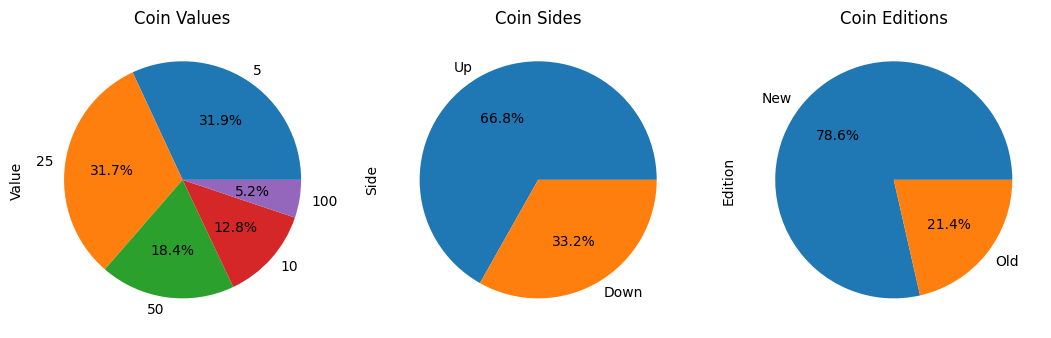

In [51]:
# Create charts
figsize = (13,13)
# Create a pie chart for the coin values
plt.subplot(1, 3, 1)
plt.title('Coin Values')
df[df['Value'] != UNKNOWN]['Value'].value_counts().plot.pie(autopct='%1.1f%%', figsize=figsize)

# Create a pie chart for the coin sides
plt.subplot(1, 3, 2)
plt.title('Coin Sides')
df[df['Side'] != UNKNOWN]['Side'].value_counts().plot.pie(autopct='%1.1f%%', figsize=figsize)

# Create a pie chart for the coin editions
plt.subplot(1, 3, 3)
plt.title('Coin Editions')
df[df['Edition'] != UNKNOWN]['Edition'].value_counts().plot.pie(autopct='%1.1f%%', figsize=figsize)

## Verify if the coins are correctly classified


In [5]:
from PIL import Image, ImageOps, ImageDraw, ImageFont
from ViaV2Json import ShapeAttributes, get_bounding_box

def crop_region(image: Image.Image, region_id: int, shape: ShapeAttributes) -> Image.Image:
    """
    Crops the region from the image, and returns the cropped image.
    """

    # Get the bounding box for the region
    topleft, bottomright = get_bounding_box(shape)

    return image.crop((*topleft, *bottomright))


In [54]:
from itertools import product
from PIL import Image
from typing import Iterable, Tuple, List

import os
import shutil

# Remove dir if it exists
if os.path.exists(SORTED_COINS_DIR):
    # Remove recursively
    shutil.rmtree(SORTED_COINS_DIR)

os.mkdir(SORTED_COINS_DIR)

count = len(images_data.values())

for image_idx, metadata in enumerate(images_data.values()):
    filename = metadata['filename']
    percent = int((image_idx + 1) / count * 100)
    
    print(f'Processing {filename}... ({percent}%)')

    with Image.open('./Moedas/' + filename) as image:
        image = ImageOps.exif_transpose(image)

        for region_id, region in enumerate(metadata['regions']):

            attributes = region['region_attributes']
            directory = f'{SORTED_COINS_DIR}/{attributes.get("Value", UNKNOWN)}'

            if not os.path.isdir(directory):
                os.mkdir(directory)

            crop = crop_region(image, region_id, region['shape_attributes'])
            crop.save(f'{directory}/{filename}_{region_id}.png')


Processing 20220827_125135.jpg... (0%)
Processing 20220827_125146.jpg... (0%)
Processing 20220827_125153.jpg... (1%)
Processing 20220827_125223.jpg... (1%)
Processing 20220827_125232.jpg... (2%)
Processing 20220827_125250.jpg... (2%)
Processing 20220827_125357.jpg... (3%)
Processing 20220827_125452.jpg... (3%)
Processing 20220827_125635.jpg... (4%)
Processing 20220827_125704.jpg... (5%)
Processing 20220827_125734.jpg... (5%)
Processing 20220827_125813.jpg... (6%)
Processing 20220827_125838.jpg... (6%)
Processing 20220827_125852.jpg... (7%)
Processing 20220827_125902.jpg... (7%)
Processing 20220827_125911.jpg... (8%)
Processing 20220827_125930.jpg... (8%)
Processing 20220827_125945.jpg... (9%)
Processing 20220827_130013.jpg... (10%)
Processing 20220827_130024.jpg... (10%)
Processing 20220827_130035.jpg... (11%)
Processing 20220827_130047.jpg... (11%)
Processing 20220827_130048.jpg... (12%)
Processing 20220827_130101.jpg... (12%)
Processing 20220827_130132.jpg... (13%)
Processing 2022082